<a href="https://colab.research.google.com/github/davidnussio/covid-19-ticino/blob/master/Covid_Ticino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
!pip install -q lmfit

     |████████████████████████████████| 266kB 2.9MB/s 
     |████████████████████████████████| 61kB 10.9MB/s 
     |████████████████████████████████| 235kB 63.8MB/s 


In [0]:
#@title
import pandas as pd
import matplotlib.pyplot as plt
import numpy 
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings
from lmfit import Model, Parameters

In [0]:
# https://www.wikiwand.com/en/Generalised_logistic_function

# Sigmoid model
def sigmoid(x, a, b, c):
  return a / (1 + numpy.exp(-b*(x-c)))

# Exponational model
def exponational(x, a, b):
  return a * numpy.exp(b * x)

# Fst derivate
def sigmoid_dx(x, a, b, c):
  return (a * b * numpy.exp(-b*(x-c))) / ((numpy.exp(-b*(x-c)) + 1) ** 2)

In [30]:
#@title Configuration

num_sample = 27 #@param {type:"slider", min:20, max:50, step:1}

moving_avarage_win = 5 #@param {type:"integer"}

print('num_sample: ',num_sample)
print('moving_avarage_win: ', moving_avarage_win)

num_sample:  27
moving_avarage_win:  5


In [31]:
# Load data from github repo (github.com/davidnussio/covid-19-ticino)
csv_data = pd.read_csv("https://raw.githubusercontent.com/davidnussio/covid-19-ticino/master/data/covid-19-ticino.csv")
data = csv_data.fillna(method='ffill')

# Daily infected patients
new_infected = csv_data['ncumul_conf'].fillna(method='ffill').diff()
new_infected[0] = 1

# Number of data days
number_of_days = len(data['ncumul_conf'])

# Cumulative infected
yData = data['ncumul_conf']

# Fit number of sample to number of days
num_sample = min(num_sample, number_of_days)

# Days vector
xData = numpy.linspace(0, number_of_days, number_of_days)
xDataSample = numpy.linspace(0, num_sample, num_sample)

# Moving avarage
r = new_infected.rolling(moving_avarage_win, center=True, win_type='gaussian')
new_infected_rolling = r.mean(std=3)

#
yData_rolling = new_infected_rolling.cumsum().fillna(0)

#yData = yData_rolling

print('Numer of sample', num_sample)
print('Number of days: ', number_of_days)
print('Date range: [', data['date'][0], '- ', data['date'][number_of_days - 1], ']')
# yData

Numer of sample 27
Number of days:  35
Date range: [ 2020-02-25 -  2020-03-30 ]


In [32]:
# Model
smodel = Model(sigmoid)
fit_params = Parameters()
fit_params.add('a', value=500, min=200, max=10000)
fit_params.add('b', value=0.05, min=0, max=5)
fit_params.add('c', value=30, min=1, max=200)
#fit_params.add('d', value=1, min=0.95, max=1.15)

result = smodel.fit(yData[:num_sample], fit_params, x=xDataSample, fit_kws={'reduce_fcn':'negentropy'})

result

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

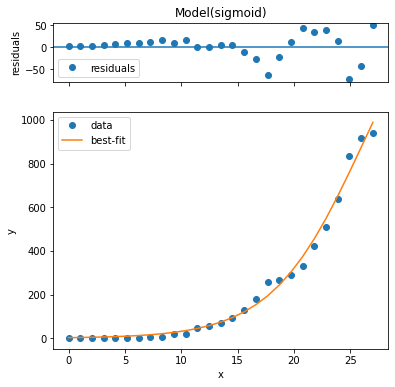

In [33]:
result.plot()

In [34]:
# Model
emodel = Model(exponational)
exp_fit_params = Parameters()
exp_fit_params.add('a', value=1, min=0.01, max=200)
exp_fit_params.add('b', value=1, min=0.01, max=5)

exp_result = emodel.fit(yData[:num_sample], exp_fit_params, x=xDataSample) #, fit_kws={'reduce_fcn':'negentropy'})

exp_result

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

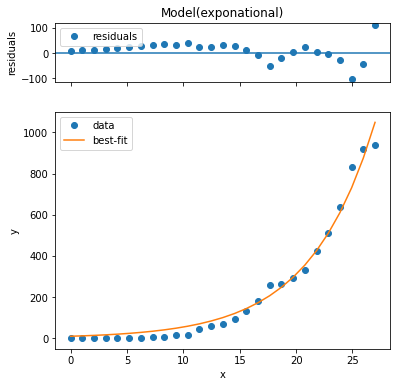

In [35]:
exp_result.plot()

In [36]:
#@title
print('Number of day', number_of_days)

# Infected guess
infected_lower = int(round(result.params['a'].value - result.params['a'].stderr))
infected_upper = int(round(result.params['a'].value + result.params['a'].stderr))
print('Infected: ', infected_lower, ' - ', infected_upper)

# Peak day
peak_day_lower = int(round(result.params['c'].value - result.params['c'].stderr))
peak_day_upper = int(round(result.params['c'].value + result.params['c'].stderr))
print('Peak day: ', peak_day_lower, ' - ', peak_day_upper)

# Date
print('Peak date: ', data['date'][peak_day_lower], ' - ', data['date'][peak_day_upper])

Number of day 35
Infected:  1452  -  2073
Peak day:  25  -  27
Peak date:  2020-03-21  -  2020-03-23


- Number of day 31
- Infected:  1779  -  2064
- Peak day:  26  -  27
- Peak date:  2020-03-22  -  2020-03-23

---

- Number of day 32
- Infected:  2040  -  2345
- Peak day:  27  -  28
- Peak date:  2020-03-23  -  2020-03-24

---

- Number of day 34
- Infected:  2209  -  2421
- Peak day:  28  -  29
- Peak date:  2020-03-24  -  2020-03-25

---

- Number of day 35
- Infected:  2304  -  2492
- Peak day:  28  -  29
- Peak date:  2020-03-24  -  2020-03-25

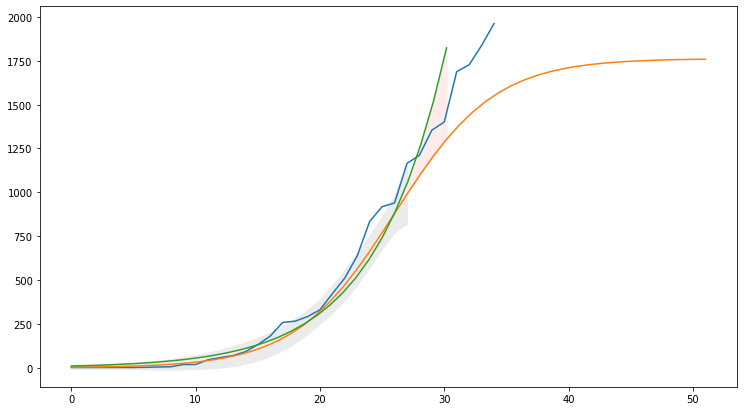

In [44]:
# Predicted n days
predicted_days = 50
x = numpy.linspace(0, predicted_days + 1, predicted_days)

ySigmoid_dx = [sigmoid_dx(i, 
                          result.params['a'].value,
                          result.params['b'].value,
                          result.params['c'].value,
                          ) for i in x]

ySigmoid = smodel.eval(result.params, x=x)
yExponential = emodel.eval(exp_result.params, x=x)

ySigmoid2 = [sigmoid(i, 
                    result.params['a'].value - result.params['a'].stderr,
                    result.params['b'].value,
                    result.params['c'].value + result.params['c'].stderr,
                    ) for i in x]

ySigmoid3 = [sigmoid(i, 
                    result.params['a'].value + result.params['a'].stderr,
                    result.params['b'].value,
                    result.params['c'].value - result.params['c'].stderr,
                    ) for i in x]

fig, ax = plt.subplots()
fig.set_size_inches(12.5, 7, forward=True)

ax.plot(data['ncumul_conf'])

# 
dely = result.eval_uncertainty(sigma=5)
exp_dely = exp_result.eval_uncertainty(sigma=5)

ax.plot(x, smodel.eval(params=result.params, x=x), label='sigmoid', zorder=100)

ax.plot(x[:30], emodel.eval(params=exp_result.params, x=x[:30]), label='exp', zorder=100)

plt.fill_between(xDataSample, result.best_fit-dely, result.best_fit+dely, color="#EBEBEB")
plt.fill_between(x[:30], 
                 smodel.eval(params=result.params, x=x[:30]), 
                 emodel.eval(params=exp_result.params, x=x[:30]), 
                 color="#ffEBEB")

plt.savefig('drive/My Drive/Colab Notebooks/Covid-Ticino/data-vs-model.png', dpi=100)

# Probability density function

**rolling average** (or moving average)

[jhsph study → 5.1 days](https://www.jhsph.edu/news/news-releases/2020/new-study-on-COVID-19-estimates-5-days-for-incubation-period.html)


<BarContainer object of 35 artists>

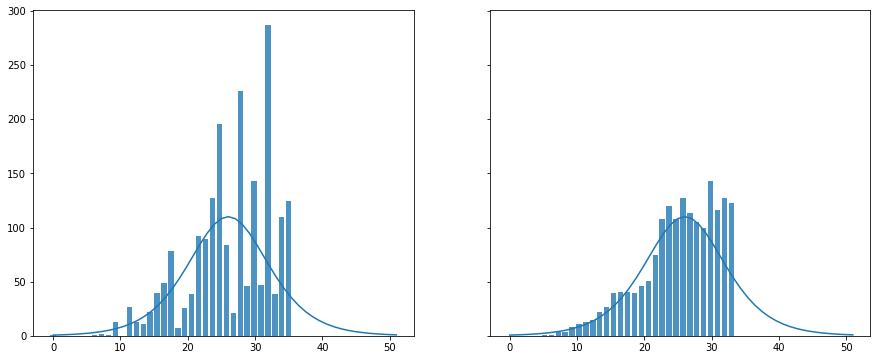

In [38]:
fig, ax = plt.subplots(1, 2, sharex='all', sharey='all')

fig.set_size_inches(15, 6, forward=True)

xInf = numpy.linspace(0, len(new_infected), len(new_infected))

ax[0].plot(x, ySigmoid_dx)
ax[0].bar(xInf, new_infected, alpha=0.8)

ax[1].plot(x, ySigmoid_dx)
ax[1].bar(xInf, new_infected_rolling, alpha=0.8)


Tomorrow prediction: 36
 ↓  1992
 →  1667
 ↑  1343


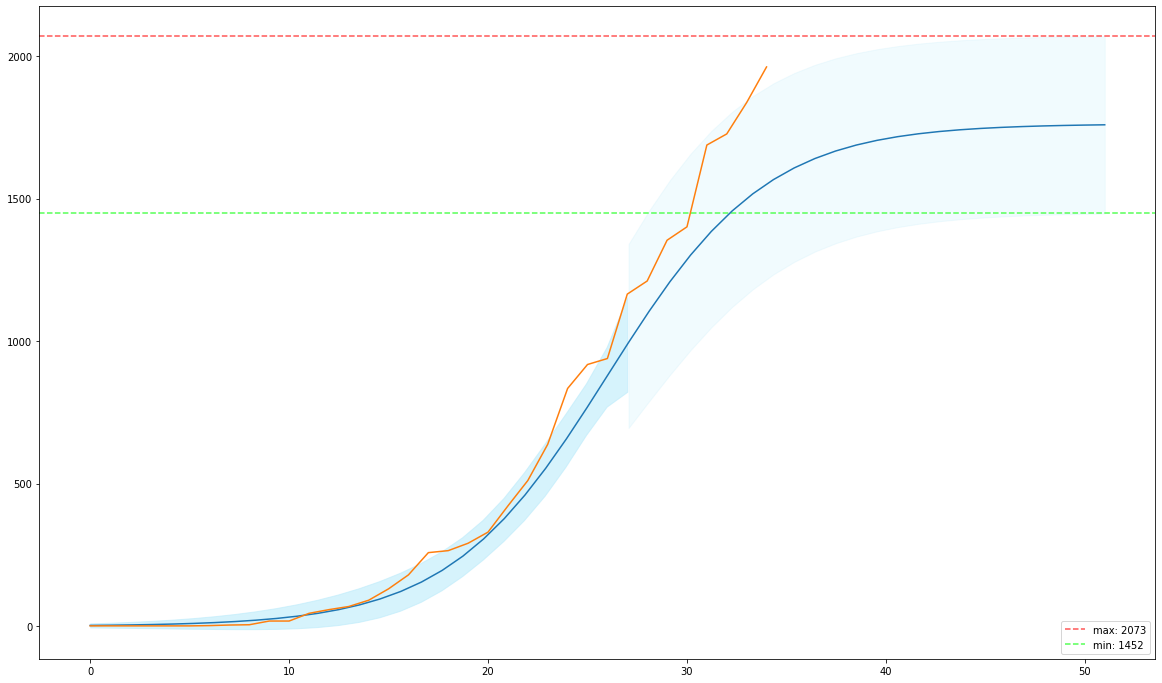

In [39]:
fig, ax = plt.subplots()

fig.set_size_inches(20, 12, forward=True)

#ax.axhline(result.params['a'].value + result.params['a'].stderr, linestyle='dashed', color='#ff5555')
#ax.axhline(result.params['a'].value - result.params['a'].stderr, linestyle='dashed', color='#55ff55')

ax.axhline(ySigmoid3[-1], linestyle='dashed', color='#ff5555')
ax.axhline(ySigmoid2[-1], linestyle='dashed', color='#55ff55')

ax.legend(("max: " + str(infected_upper), "min: " + str(infected_lower)))

next_data = len(result.best_fit) - 1

ax.fill_between(x[next_data:], ySigmoid2[next_data:], ySigmoid3[next_data:], color="#bbebfb", alpha=0.2)

ax.plot(x, ySigmoid)

plt.fill_between(xDataSample, result.best_fit-dely, result.best_fit+dely, color="#bbebfb", alpha=0.6)

ax.plot(data['ncumul_conf'])

print('Tomorrow prediction:', number_of_days + 1)
print(' ↓ ', int(round(ySigmoid3[number_of_days + 1])))
print(' → ', int(round(ySigmoid[number_of_days + 1])))
print(' ↑ ', int(round(ySigmoid2[number_of_days + 1])))



ValueError: ignored

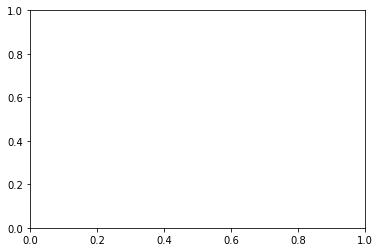

In [40]:
skip_data = 25
ncumul_hosp = data['ncumul_hosp'][skip_data:].fillna(0)
ncumul_ICU = data['ncumul_ICU'][skip_data:].fillna(0)
ncumul_deceased = data['ncumul_deceased'][skip_data:].fillna(0)

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

#ax.bar(xDataSample, ncumul_hosp, width, label='ncumul_hosp')
ax.bar(xDataSample[skip_data:], ncumul_ICU, width, label='Intensive Care')
ax.bar(xDataSample[skip_data:], ncumul_deceased, width, bottom=ncumul_ICU, label='Deceased')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()

plt.show()